In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym
import numpy as np
from matplotlib import pyplot as plt
import random
from collections import namedtuple
from matplotlib import animation as anime

In [2]:
xval = []
yval = []
yavg = []
def animate(i):
    plt.cla()
    plt.plot(xval, yval, 'r*')


In [3]:
env = gym.make('CartPole-v1')

In [4]:
class Agent(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(env.observation_space.shape[0], 420)
        self.fc2 = nn.Linear(420, 128)
        self.fc3 = nn.Linear(128, env.action_space.n)

    def forward(self, x):
        # print(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=1)
        # return x

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [6]:
class LearnAcrobot:
    def __init__(self, d_size, episodes):
        self.D_SIZE = d_size
        self.EPISODES = episodes
        self.model = Agent().to(device)
        self.optim = optim.Adam(self.model.parameters(),  lr=8e-3)
        self.trajectory = []
        self.batch_states = []
        self.batch_actions = []
        self.batch_returns = []
        self.batch_Rtau = []
        self.log_probs = []
        self.rewards = []
        self.probs = []

    def makePolicy(self, s):
        logits = self.model(s.to(device))
        # print(logits)
        return torch.distributions.Categorical(logits=logits)

    def takeAction(self, s):
        # s = self.model(torch.as_tensor(s).float().unsqueeze(0))
        # prob = torch.distributions.Categorical(logits=s)
        # act = prob.sample()
        # # act = torch.argmax(s)
        # # print(prob.log_prob(act))
        # # self.log_probs[indx].append(prob.log_prob(act))
        # return act.item(), prob.log_prob(act), s[0][act]
        return self.makePolicy(s).sample().item()

    def computeGradientJ(self, s, act, rTau):
        # print(s)
        logp = self.makePolicy(s).log_prob(act)
        # print(rTau, logp)
        return -(logp * rTau).mean()

    def train(self):
        self.optim.zero_grad()
        loss = self.computeGradientJ(torch.as_tensor(self.batch_states).float().to(device),
                                     torch.as_tensor(self.batch_actions).int().to(device),
                                     torch.as_tensor(self.batch_Rtau).float().to(device))
        loss.backward()
        self.optim.step()
        g = self.batch_Rtau[0]
        self.batch_Rtau = []
        self.batch_actions = []
        self.batch_states = []
        self.batch_returns = []
        return g, loss


In [7]:
acro = LearnAcrobot(420, 500)

In [8]:
win_count = 0
render = True
for i in range(1, acro.EPISODES):
    
    while len(acro.batch_states) < (acro.D_SIZE):
        done = False
        state = env.reset()
        eps_rew = []

        while not done:
            acro.batch_states.append(state.copy())

            action = acro.takeAction(torch.as_tensor(state).float().unsqueeze(0))
            new_state, reward, done, _ = env.step(action)

            acro.batch_actions.append(action)
            eps_rew.append(reward)

            if done:
                acro.batch_returns.append(sum(eps_rew))
                acro.batch_Rtau += [sum(eps_rew)] * len(eps_rew)
            state = new_state
            # if state[0] >= env.goal_position:
            #     win_count += 1
            #     print('we made it')

            if render:
                env.render()
        render = False
    # if i%100 == 0:
    #     print(loss)
    g, loss = acro.train()
    # print(g)
    xval.append(i)
    yval.append(g)
    yavg.append(sum(yval)/i)
    # if i%20 ==0:
    print(f'Loss at {i} is ', loss, f' And return is {g}')
    render = True


s at 283 is  tensor(39.2807, device='cuda:0', grad_fn=<NegBackward>)  And return is 31.0
Loss at 284 is  tensor(43.2466, device='cuda:0', grad_fn=<NegBackward>)  And return is 67.0
Loss at 285 is  tensor(41.7434, device='cuda:0', grad_fn=<NegBackward>)  And return is 66.0
Loss at 286 is  tensor(45.8020, device='cuda:0', grad_fn=<NegBackward>)  And return is 36.0
Loss at 287 is  tensor(30.9479, device='cuda:0', grad_fn=<NegBackward>)  And return is 45.0
Loss at 288 is  tensor(37.1864, device='cuda:0', grad_fn=<NegBackward>)  And return is 57.0
Loss at 289 is  tensor(40.5546, device='cuda:0', grad_fn=<NegBackward>)  And return is 78.0
Loss at 290 is  tensor(46.6521, device='cuda:0', grad_fn=<NegBackward>)  And return is 63.0
Loss at 291 is  tensor(57.1484, device='cuda:0', grad_fn=<NegBackward>)  And return is 133.0
Loss at 292 is  tensor(29.3186, device='cuda:0', grad_fn=<NegBackward>)  And return is 70.0
Loss at 293 is  tensor(43.5671, device='cuda:0', grad_fn=<NegBackward>)  And retur

0


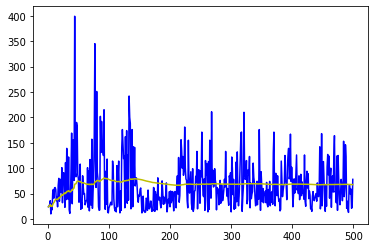

In [9]:
print(win_count)
env.close()
plt.plot(xval, yval, 'b')
plt.plot(xval, yavg, 'y')
plt.show()
plt.close()